In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import my_functions
import sklearn
import torch
import time
import os
import mplhep as hep
import boost_histogram as bh

plan
- nicer plot of cost for training and cost for test at each epoch

In [2]:

def read_h5(filename):
    dic = {}
    with h5py.File(filename, 'r') as h5_file:
        group = h5_file['Objects']
        for name in group.keys():
            data = np.array(group[name])
            dic[name] = data
    return pd.DataFrame(dic)


In [3]:
data_frame = {}
data_frame['tttt_even'] = read_h5('tttt_even.h5')
data_frame['tttt_odd'] = read_h5('tttt_odd.h5')

In [132]:
list(data_frame['tttt_odd'].keys())

['HT',
 'average_R',
 'average_eta',
 'average_phi',
 'average_rapidity',
 'greatest_R',
 'greatest_eta',
 'greatest_mass',
 'greatest_phi',
 'greatest_pt',
 'greatest_rapidity',
 'leading_pt_alignment',
 'leading_tbarpt_ttbar_alignment',
 'leading_tpt_ttbar_alignment',
 'min_R',
 'min_eta',
 'min_phi',
 'min_rapidity',
 'overall_diff_pt',
 'overall_max_pt',
 'overall_min_R',
 'overall_min_pt',
 'tbartbar_R',
 'tbartbar_alignment',
 'tbartbar_eta',
 'tbartbar_m',
 'tbartbar_phi',
 'tbartbar_pt',
 'tbartbar_rapidity',
 'tt_R',
 'tt_alignment',
 'tt_eta',
 'tt_m',
 'tt_phi',
 'tt_pt',
 'tt_rapidity',
 'ttbar_pt_smallest_dR',
 'tttt_m']

In [4]:
#ML_inputs = ['ttbar_pt_smallest_dR']
ML_inputs = list(data_frame['tttt_odd'].keys())

X = np.concatenate([data_frame['tttt_even'][ML_inputs], data_frame['tttt_odd'][ML_inputs]])
y = np.concatenate([np.zeros(data_frame['tttt_even'].shape[0]), np.ones(data_frame['tttt_odd'].shape[0])])
y

array([0., 0., 0., ..., 1., 1., 1.])

In [40]:
from sklearn.model_selection import train_test_split


seed_value = 270603
np.random.seed(seed_value)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed_value
)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [41]:
X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)
X_train_var, y_train_var = torch.autograd.Variable(X_train_tensor), torch.autograd.Variable(y_train_tensor)
X_test_tensor = torch.as_tensor(X_test_scaled, dtype=torch.float)  # make tensor from X_train_scaled
y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)
X_test_var, y_test_var = torch.autograd.Variable(X_test_tensor), torch.autograd.Variable(y_test_tensor)

# X_valid_var, y_valid_var = (
#     X_train_var[:100],
#     y_train_var[:100],
# )  # get first 100 events for validation - to check at the end (i don't really understand this step)
# X_train_nn_var, y_train_nn_var = (
#     X_train_var[100:],
#     y_train_var[100:],
# )  # get remaining events for training


X_valid_var, y_valid_var = (
    X_test_var,
    y_test_var,
)
X_train_nn_var, y_train_nn_var = (
    X_train_var,
    y_train_var,
)  # get remaining events for training

train_data = torch.utils.data.TensorDataset(
    X_train_nn_var, y_train_nn_var
)  # create training dataset
valid_data = torch.utils.data.TensorDataset(X_valid_var, y_valid_var) 





In [42]:
class Classifier_MLP(torch.nn.Module):  # define Multi-Layer Perceptron
    def __init__(self, in_dim, hidden_dims, out_dim):  # initialise
        super().__init__()  # lets you avoid referring to the base class explicitly

        # Create a list to hold all layers
        layers = []

        # Add the input layer
        prev_dim = in_dim
        for hidden_dim in hidden_dims:
            layers.append(torch.nn.Linear(prev_dim, hidden_dim))
            layers.append(torch.nn.ReLU())
            prev_dim = hidden_dim

        # Add the output layer
        layers.append(torch.nn.Linear(prev_dim, out_dim))

        # Use Sequential to combine all layers
        self.model = torch.nn.Sequential(*layers)

        self.out_dim = out_dim  # output layer dimension

    def forward(self, x):  # order of the layers
        logits = self.model(x)
        probabilities = torch.nn.functional.softmax(logits, dim=1)

        return logits, probabilities  # Return both logits and probabilities

In [1]:
3.5**2/4.1


2.987804878048781

In [43]:
def general_train(epochs, batch_size, input_size, num_classes, hidden_dims, learning_rate, verbose, learn_type = 'SGD'):
    t1 = time.perf_counter()
    train_loader = torch.utils.data.DataLoader(
        dataset=train_data,  # PyTorch Dataset
        batch_size=batch_size,  # how many samples per batch to load
        shuffle=True,
    )  # data reshuffled at every epoch

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_data,  # PyTorch Dataset
        batch_size=batch_size,  # how many samples per batch to load
        shuffle=True,
    )  # data reshuffled at every epoch

    NN_clf = Classifier_MLP(in_dim=input_size, hidden_dims=hidden_dims, out_dim=num_classes)  # call Classifier_MLP class
    if learn_type == 'Adam':
        optimizer = torch.optim.Adam(NN_clf.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(NN_clf.parameters(), lr=learning_rate)  # optimize model parameters
    # # using gradient decent optimiser 
    
        
    results = []  # define empty list for epoch, train_loss, valid_loss, accuracy
    t_last = time.perf_counter()
    for epoch in range(epochs):  # loop over the dataset multiple times

        # training loop for this epoch
        NN_clf.train()  # set the model into training mode

        train_loss = 0.0  # start training loss counter at 0
        # split each epoch into batches
        for batch, (x_train_batch, y_train_batch) in enumerate(train_loader): 
            # loop over train_loader
            # defined train_loader with shuffle = true so that the data is not identical each time

            NN_clf.zero_grad()  # set the gradients to zero before backpropragation because PyTorch accumulates the gradients
            out, prob = NN_clf(
                x_train_batch
            )  # get output and probability on this training batch
            loss = torch.nn.functional.cross_entropy(out, y_train_batch)  # calculate loss as cross entropy

            loss.backward()  # compute dloss/dx
            optimizer.step()  # updates the parameters

            train_loss += loss.item() * x_train_batch.size(0)  # add to counter for training loss

        train_loss /= len(train_loader.dataset)  # divide train loss by length of train_loader

        if verbose:  # if verbose flag set to True
            #print("Epoch: {}, Train Loss: {:4f}".format(epoch, train_loss))
            t_current = time.perf_counter()
            print(f'time for epoch: {np.round(t_current-t_last, 2)} s')
            t_last = t_current

        # validation loop for this epoch:
        NN_clf.eval()  # set the model into evaluation mode
        with torch.no_grad():  # turn off the gradient calculations

            out, prob = NN_clf(X_test_var)  # get output and probabilities from X
            valid_loss = torch.nn.functional.cross_entropy(out, y_test_var,reduction = 'mean')
            y_pred_NN = prob.cpu().detach().numpy().argmax(axis=1)
            valid_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred_NN)

            out, prob = NN_clf(X_train_var)  # get output and probabilities from X
            train_loss = torch.nn.functional.cross_entropy(out, y_train_var, reduction = 'mean')
            y_pred_NN = prob.cpu().detach().numpy().argmax(axis=1)
            train_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred_NN)

            # correct = 0
            # valid_loss = 0  # start counters for number of correct and validation loss
            # for i, (x_valid_batch, y_valid_batch) in enumerate(
            #     valid_loader
            # ):  # loop over validation loader

            #     out, prob = NN_clf(
            #         x_valid_batch
            #     )  # get output and probability on this validation batch
            #     loss = torch.nn.functional.cross_entropy(out, y_valid_batch)  # compute loss as cross entropy

            #     valid_loss += loss.item() * x_valid_batch.size(0)  # add to counter for validation loss

            #     preds = prob.argmax(dim=1, keepdim=True)  # get predictions
            #     correct += (
            #         preds.eq(y_valid_batch.view_as(preds)).sum().item()
            #     )  # count number of correct

            # valid_loss /= len(valid_loader.dataset)  # divide validation loss by length of validation dataset
            # accuracy = correct / len(
            #     valid_loader.dataset
            # )  # calculate accuracy as number of correct divided by total

        if verbose:  # if verbose flag set to True
            print("Epoch: {}, Train Loss: {:4f}, Train Accuracy: {:4f}".format(epoch, train_loss, train_accuracy))
            print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, valid_accuracy))
        # create output row:
        results.append([train_loss, valid_loss, train_accuracy, valid_accuracy])

    results = np.array(results)  # make array of results
    print("Finished Training")
    print("Final validation error: ", 100.0 * (1 - valid_accuracy), "%")   
    return NN_clf, np.round(time.perf_counter() - t1, 2), results


def find_accuracy(NN_clf, X_data, y_data, string):
    X_scaled = scaler.transform(X_data)
    X_tensor = torch.as_tensor(X_scaled, dtype=torch.float)  
    # make tensor from X_test_scaled for testing data
    y_tensor = torch.as_tensor(y_data, dtype=torch.long)  
    # make tensor from y_test

    X_var, y_var = torch.autograd.Variable(X_tensor), torch.autograd.Variable(
        y_tensor
    )  # make variables from tensors

    out, prob = NN_clf(X_var)  # get output and probabilities from X
    y_pred_NN = (
        prob.cpu().detach().numpy().argmax(axis=1)
    )  # get signal/background predictions

    loss = torch.nn.functional.cross_entropy(out, y_var)
    accuracy = sklearn.metrics.accuracy_score(y_data, y_pred_NN)
    print(f'{string} accuracy : {accuracy},   cost : {loss.item()}')
    return y_pred_NN, accuracy, loss.item()

In [44]:
from sklearn.ensemble import RandomForestClassifier # random forest is a collectino of desision trees (black box)
RF_clf = RandomForestClassifier(
    criterion="gini", max_depth=8, n_estimators=30, random_state=seed_value
)  # initialise your random forest classifier
# max depth refers to depth of each individual tree in the emsemble 
# number of estimators is number of trees
RF_clf.fit(X_train_scaled, y_train)  # fit to the training data
y_pred_RF = RF_clf.predict(X_test_scaled)  # make predictions on the test data

# See how well the classifier does
print(sklearn.metrics.accuracy_score(y_test, y_pred_RF))

KeyboardInterrupt: 

In [45]:
epochs = 40  # number of training epochs
batch_size = 32  # number of samples per batch
input_size = len(ML_inputs)  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_dims = [32]  # The number of nodes at the hidden layer
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch
torch.manual_seed(seed_value)  # set random seed for PyTorch

NN_clf, training_time, results = general_train(epochs, batch_size, input_size, num_classes, hidden_dims, learning_rate, verbose)


time for epoch: 23.11 s
Epoch: 0, Train Loss: 0.689667, Train Accuracy: 0.535097
Validation Loss: 0.689593, Validation Accuracy: 0.535725
time for epoch: 25.8 s
Epoch: 1, Train Loss: 0.689165, Train Accuracy: 0.537190
Validation Loss: 0.689081, Validation Accuracy: 0.537037
time for epoch: 24.16 s
Epoch: 2, Train Loss: 0.688875, Train Accuracy: 0.538556
Validation Loss: 0.688797, Validation Accuracy: 0.539308
time for epoch: 23.52 s
Epoch: 3, Train Loss: 0.688764, Train Accuracy: 0.539043
Validation Loss: 0.688702, Validation Accuracy: 0.539046
time for epoch: 24.71 s
Epoch: 4, Train Loss: 0.688662, Train Accuracy: 0.539289
Validation Loss: 0.688618, Validation Accuracy: 0.539896
time for epoch: 25.5 s
Epoch: 5, Train Loss: 0.688565, Train Accuracy: 0.539709
Validation Loss: 0.688539, Validation Accuracy: 0.540021
time for epoch: 26.77 s
Epoch: 6, Train Loss: 0.688521, Train Accuracy: 0.539906
Validation Loss: 0.688511, Validation Accuracy: 0.540142
time for epoch: 26.43 s
Epoch: 7, Tr

In [46]:
find_accuracy(NN_clf, X, y, 'overall ')
_, train_accuracy, train_loss = find_accuracy(NN_clf, X_train, y_train, 'training')
y_pred_NN, test_accuracy, test_loss = find_accuracy(NN_clf, X_test, y_test, 'test    ')

print(sklearn.metrics.classification_report(y_test, y_pred_NN, target_names=["background", "signal"]))


overall  accuracy : 0.5420058333333333,   cost : 0.6880562901496887
training accuracy : 0.5420427083333333,   cost : 0.688029944896698
test     accuracy : 0.5418583333333333,   cost : 0.6881616711616516
              precision    recall  f1-score   support

  background       0.54      0.57      0.55    119905
      signal       0.54      0.52      0.53    120095

    accuracy                           0.54    240000
   macro avg       0.54      0.54      0.54    240000
weighted avg       0.54      0.54      0.54    240000



In [11]:
def save_comparison():
    file_path = 'performance_comparison2.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
    else:
        df = pd.DataFrame()


    # Data to append
    data_to_append = {
        'layers': [str(hidden_dims)],
        'learn rate': [learning_rate],
        'epochs': [epochs],
        'batch size' : [batch_size],
        'training cost' : [train_loss],
        'test cost' : [test_loss],
        'training accuracy': [train_accuracy],
        'test accuracy': [test_accuracy],
        'training time': [training_time],
        'training time per epoch' : [training_time/epochs]
    }

    df_to_append = pd.DataFrame(data_to_append)
    df = df.dropna(how='all', axis=1)
    df_to_append = df_to_append.dropna(how='all', axis=1)

    # Concatenate the existing DataFrame with the new data
    df = pd.concat([df, df_to_append], ignore_index=True)

    # Write the updated DataFrame back to the CSV file
    df.to_csv('performance comparison.csv', index=False)

In [13]:
X_even = np.concatenate([data_frame['tttt_even'][ML_inputs]])
X_even_scaled = scaler.transform(X_even)
X_even_tensor = torch.as_tensor(X_even_scaled, dtype=torch.float)  
X_even_var = torch.autograd.Variable(X_even_tensor)


X_odd = np.concatenate([data_frame['tttt_odd'][ML_inputs]])
X_odd_scaled = scaler.transform(X_odd)
X_odd_tensor = torch.as_tensor(X_odd_scaled, dtype=torch.float)  
X_odd_var = torch.autograd.Variable(X_odd_tensor)

X_tensor = torch.as_tensor(X_scaled, dtype=torch.float)  
X_var = torch.autograd.Variable(X_tensor)


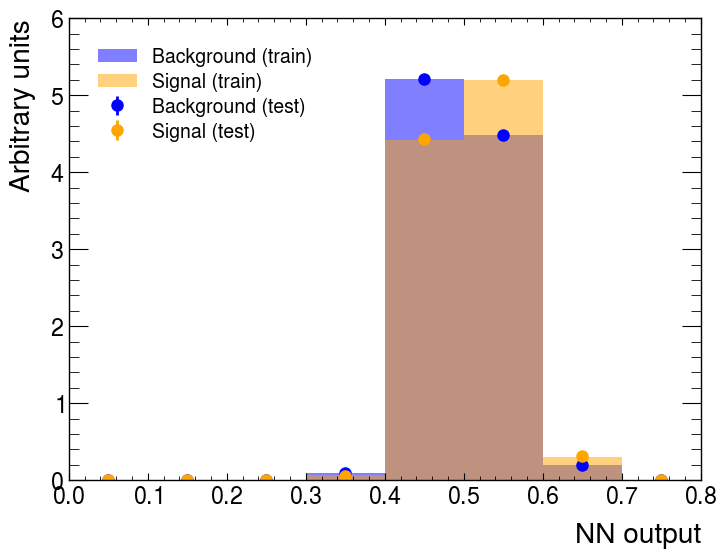

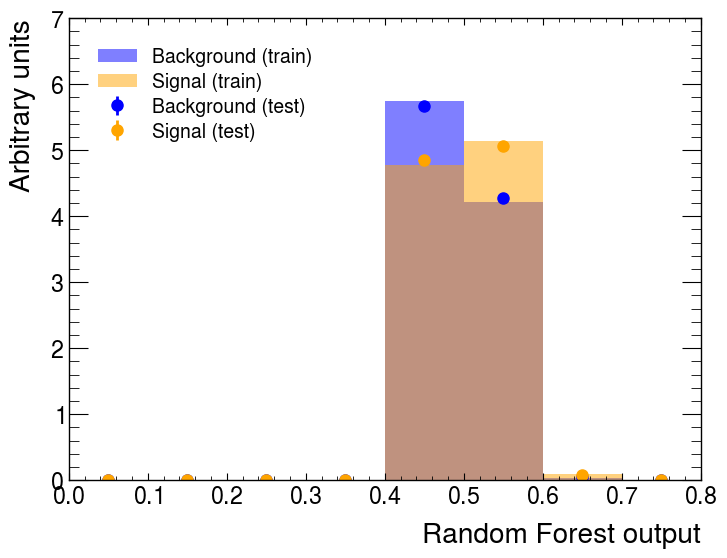

In [37]:
my_functions.compare_train_test(
    NN_clf, X_train_scaled, y_train, X_test_scaled, y_test, "NN output"
)
plt.show()

my_functions.compare_train_test(
    RF_clf, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest output"
)
plt.show()

# not sure what brown is 

In [48]:
def plot_signal_background(NN_clf, dim, results):
    _, prob_odd = NN_clf(X_odd_var)
    y_pred_NN_odd = prob_odd.cpu().detach().numpy()[:,1]

    _, prob_even = NN_clf(X_even_var)
    y_pred_NN_even = prob_even.cpu().detach().numpy()[:,1]

    hep.style.use(hep.style.ATLAS)
    hist1 = bh.Histogram(bh.axis.Regular(100, 0, 1)) # Initialises empty histogram with 50 bins spanning [0,500]
    hist2 = bh.Histogram(bh.axis.Regular(100, 0, 1))
    hist1.fill(y_pred_NN_even)    # Fills the histogram with some data
    hist2.fill(y_pred_NN_odd)


    hep.histplot([hist1/hist1.size, hist2/hist2.size], label = ['even', 'odd'])
    plt.xlabel('signal confidence')
    plt.ylabel('Normalized Frequency')
    plt.title(f'signal background {dim}')
    plt.legend()
    #plt.savefig(f'using_adam_images\{dim} signal plot background.png')
    plt.show()


    hep.style.use(hep.style.ATLAS)
    hist1 = bh.Histogram(bh.axis.Regular(100, 0.3, 0.7)) # Initialises empty histogram with 50 bins spanning [0,500]
    hist2 = bh.Histogram(bh.axis.Regular(100, 0.3, 0.7))
    hist1.fill(y_pred_NN_even)    # Fills the histogram with some data
    hist2.fill(y_pred_NN_odd)


    hep.histplot([hist1/hist1.size, hist2/hist2.size], label = ['even', 'odd'])
    plt.xlabel('signal confidence')
    plt.ylabel('Normalized Frequency')
    plt.title(f'signal background plot zoomed {dim}')
    plt.legend()
    #plt.savefig(f'using_adam_images\{dim} signal background zoomed.png')
    plt.show()

    decisions_nn = (NN_clf(X_var)[1][:, 1].cpu().detach().numpy())  # get the decisions of the neural network
    fpr_nn, tpr_nn, thresholds_nn = sklearn.metrics.roc_curve(y, decisions_nn)  # get FPRs, TPRs and thresholds for neural network

    # decisions_rf = RF_clf.predict_proba(X_scaled)[:, 1]  # get the decisions of the random forest  # get the decisions of the neural network
    # fpr_rf, tpr_rf, thresholds_rf = sklearn.metrics.roc_curve(y, decisions_rf)  # get FPRs, TPRs and thresholds for neural network

    # plt.plot(fpr_nn, tpr_nn, linestyle="dashed", label="Neural Network")  # plot neural network ROC
    # plt.plot(fpr_rf, tpr_rf, linestyle="dashed", label="Random Forest")
    # plt.plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")  # plot diagonal line to indicate luck
    # plt.xlabel("False Positive Rate")  # x-axis label
    # plt.ylabel("True Positive Rate")  # y-axis label
    # plt.ylim(0,1)
    # plt.title(f'ROC plot for {dim}')
    # plt.grid()  # add a grid to the plot
    # plt.legend()  # add a legend
    # #plt.savefig(f'using_adam_images\{dim} ROC plot.png')
    # plt.show()


    plt.plot(np.arange(len(results)), results[:,0],linestyle='-', marker='o',  label = 'train cost')
    plt.plot(np.arange(len(results)), results[:,1], linestyle='-', marker='o', label = 'test cost')
    plt.xlabel("Epochs")  # x-axis label
    plt.ylabel("Loss")  # y-axis label
    plt.title(f'Loss at each Epoch for {dim}')
    plt.legend()
    #plt.savefig(f'using_adam_images\{dim} cost at each epoch.png')
    plt.show()

    plt.plot(np.arange(len(results)), results[:,2],linestyle='-', marker='o',  label = 'train accuracy')
    plt.plot(np.arange(len(results)), results[:,3], linestyle='-', marker='o', label = 'test accuracy')
    plt.xlabel("Epochs")  # x-axis label
    plt.ylabel("Loss")  # y-axis label
    plt.title(f'Accuracy at each Epoch for {dim}')
    plt.legend()
    #plt.savefig(f'using_adam_images\{dim} cost at each epoch.png')
    plt.show()



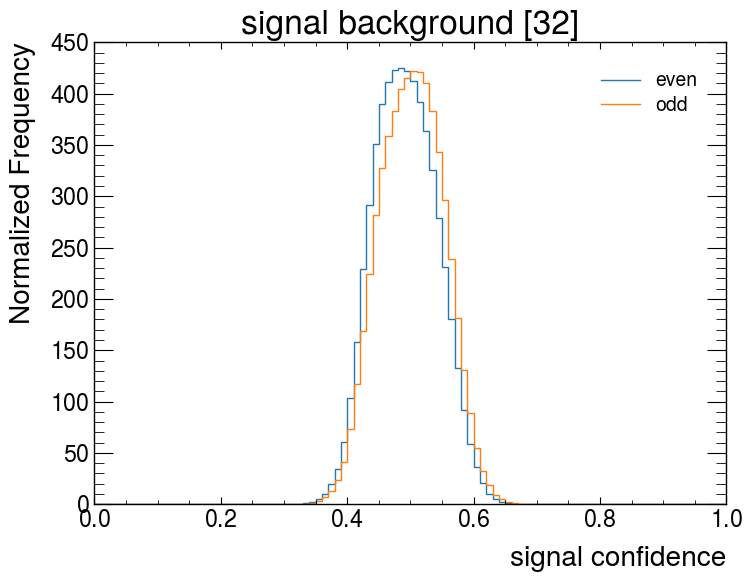

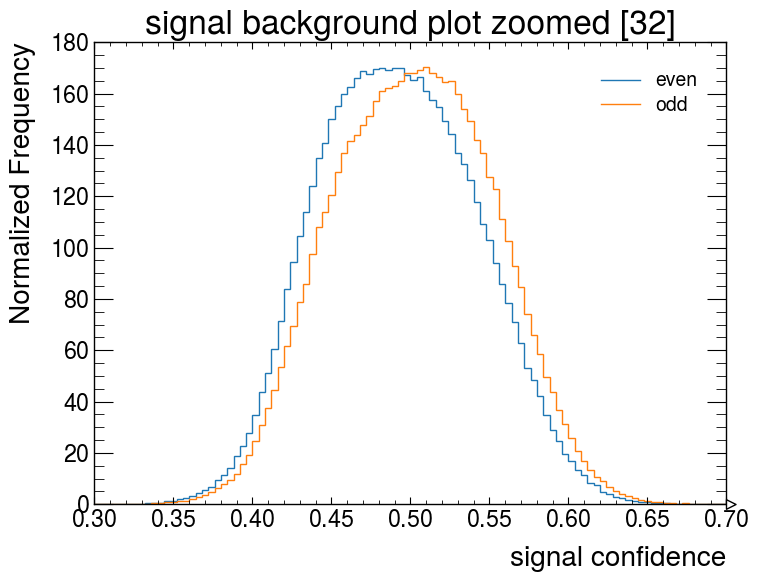

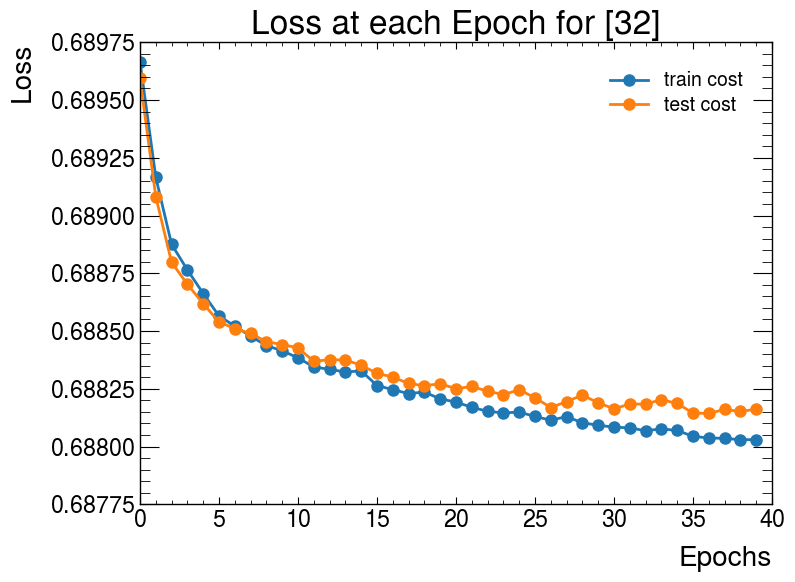

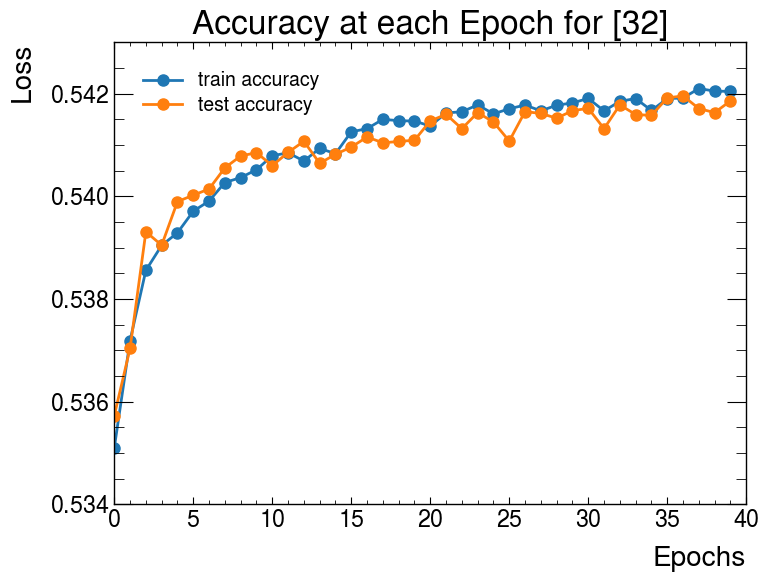

In [49]:
#results = [1,0.9,0.6,0.4]
plot_signal_background(NN_clf, [32], results)

In [160]:
#dimes = [[4],[4,4],[4,4,4],[8],[8,8]] # ,[8,8,8],[8,4,4],[16],[16,16],[16,16,16], [16,8,4],[32],[32,32],[32,16],[32,8], [32,16,8], [32,8,4], [64], [64,16], [64,16,8], [64,16,8,4]]
dimes = [[64],[32],[16],[8], [128], [64,16]]


def do_it_all(dimes, learn_type = 'SGD'):
    epochs = 15  # number of training epochs
    batch_size = 32  # number of samples per batch
    input_size = len(ML_inputs)  # The number of features
    num_classes = 2  # The number of output classes. In this case: [signal, background]  # The number of nodes at the hidden layer
    learning_rate = 0.001  # The speed of convergence
    verbose = True  # flag for printing out stats at each epoch
    torch.manual_seed(seed_value)  # set random seed for PyTorch
    models = {}
    for hidden_dims in dimes:
        NN_clf, training_time, losses = general_train(epochs, batch_size, input_size, num_classes, hidden_dims, learning_rate, verbose, learn_type = learn_type)
        find_accuracy(NN_clf, X, y, 'overall ')
        _, train_accuracy, train_loss = find_accuracy(NN_clf, X_train, y_train, 'training')
        y_pred_NN, test_accuracy, test_loss = find_accuracy(NN_clf, X_test, y_test, 'test    ')

        print(sklearn.metrics.classification_report(y_test, y_pred_NN, target_names=["background", "signal"]))
        plot_signal_background(NN_clf, hidden_dims, losses)
        torch.save(NN_clf.state_dict(), f'models\model {hidden_dims} {learn_type}.pth')
        models[f'{dimes} {learn_type}'] = NN_clf
    return models
        
        
    

Epoch: 0, Train Loss: 0.689570
time for epoch: 28.83 s
Validation Loss: 0.702560, Validation Accuracy: 0.410000
Epoch: 1, Train Loss: 0.688997
time for epoch: 34.36 s
Validation Loss: 0.694632, Validation Accuracy: 0.470000
Epoch: 2, Train Loss: 0.688848
time for epoch: 36.11 s
Validation Loss: 0.688996, Validation Accuracy: 0.540000
Epoch: 3, Train Loss: 0.688694
time for epoch: 37.93 s
Validation Loss: 0.694904, Validation Accuracy: 0.500000
Epoch: 4, Train Loss: 0.688678
time for epoch: 38.52 s
Validation Loss: 0.696599, Validation Accuracy: 0.450000
Epoch: 5, Train Loss: 0.688590
time for epoch: 39.16 s
Validation Loss: 0.687103, Validation Accuracy: 0.520000
Epoch: 6, Train Loss: 0.688582
time for epoch: 41.84 s
Validation Loss: 0.689298, Validation Accuracy: 0.490000
Epoch: 7, Train Loss: 0.688554
time for epoch: 46.64 s
Validation Loss: 0.689266, Validation Accuracy: 0.500000
Epoch: 8, Train Loss: 0.688550
time for epoch: 42.7 s
Validation Loss: 0.689944, Validation Accuracy: 0.

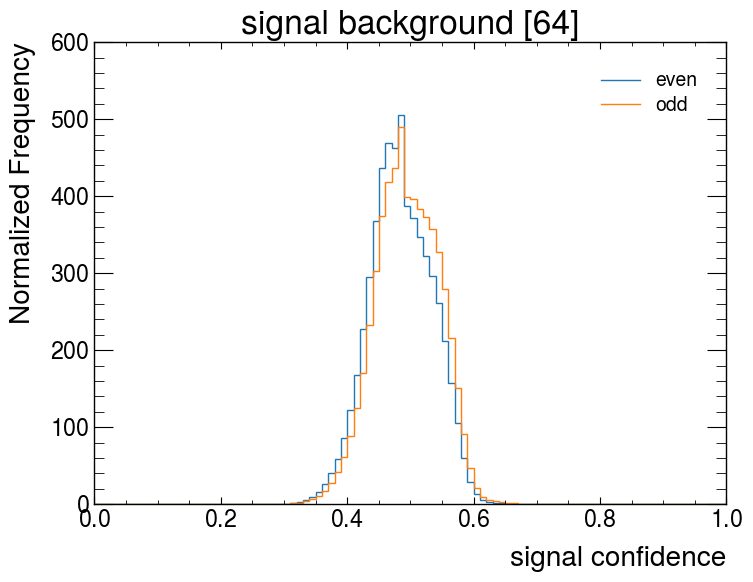

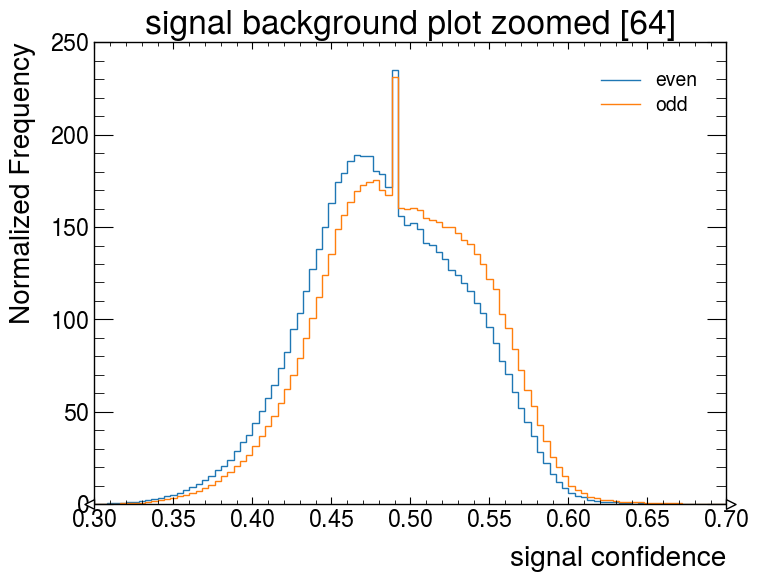

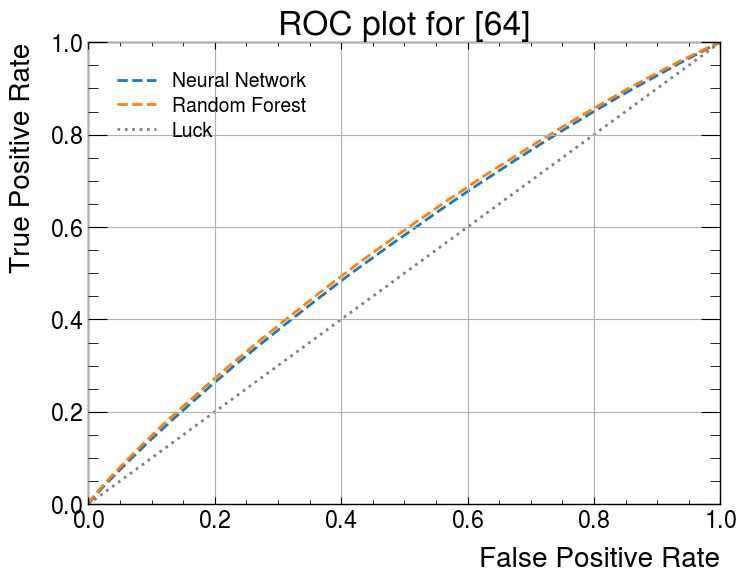

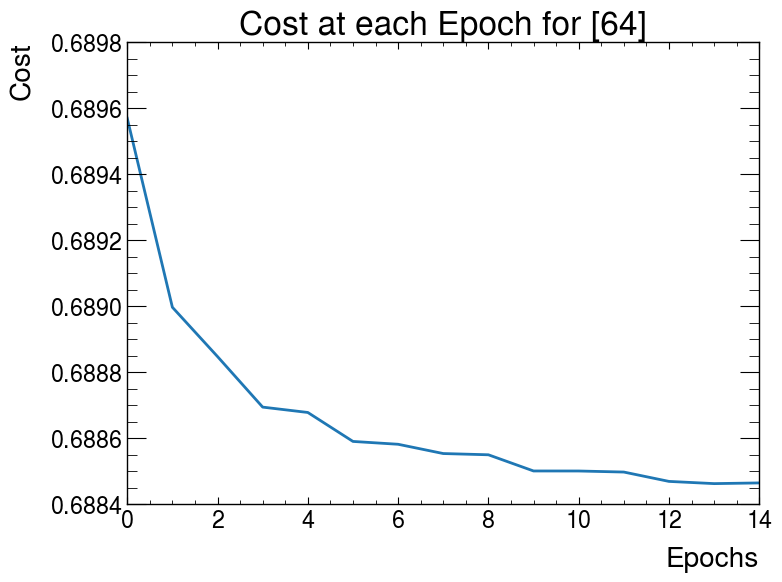

Epoch: 0, Train Loss: 0.689313
time for epoch: 42.6 s
Validation Loss: 0.690852, Validation Accuracy: 0.500000
Epoch: 1, Train Loss: 0.688894
time for epoch: 40.16 s
Validation Loss: 0.693960, Validation Accuracy: 0.490000
Epoch: 2, Train Loss: 0.688739
time for epoch: 39.24 s
Validation Loss: 0.699920, Validation Accuracy: 0.440000
Epoch: 3, Train Loss: 0.688680
time for epoch: 38.78 s
Validation Loss: 0.695456, Validation Accuracy: 0.460000
Epoch: 4, Train Loss: 0.688616
time for epoch: 39.87 s
Validation Loss: 0.693943, Validation Accuracy: 0.490000
Epoch: 5, Train Loss: 0.688577
time for epoch: 47.55 s
Validation Loss: 0.693291, Validation Accuracy: 0.450000
Epoch: 6, Train Loss: 0.688611
time for epoch: 44.17 s
Validation Loss: 0.697207, Validation Accuracy: 0.480000
Epoch: 7, Train Loss: 0.688540
time for epoch: 40.46 s
Validation Loss: 0.695134, Validation Accuracy: 0.480000
Epoch: 8, Train Loss: 0.688534
time for epoch: 42.17 s
Validation Loss: 0.692068, Validation Accuracy: 0.

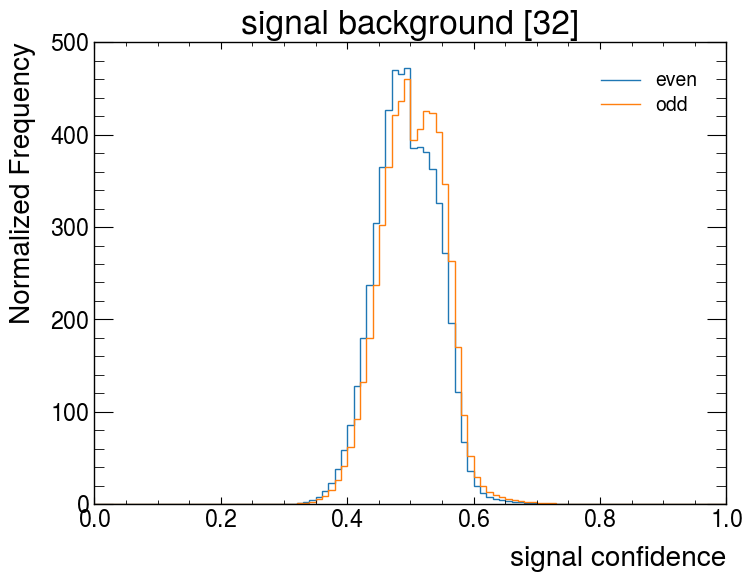

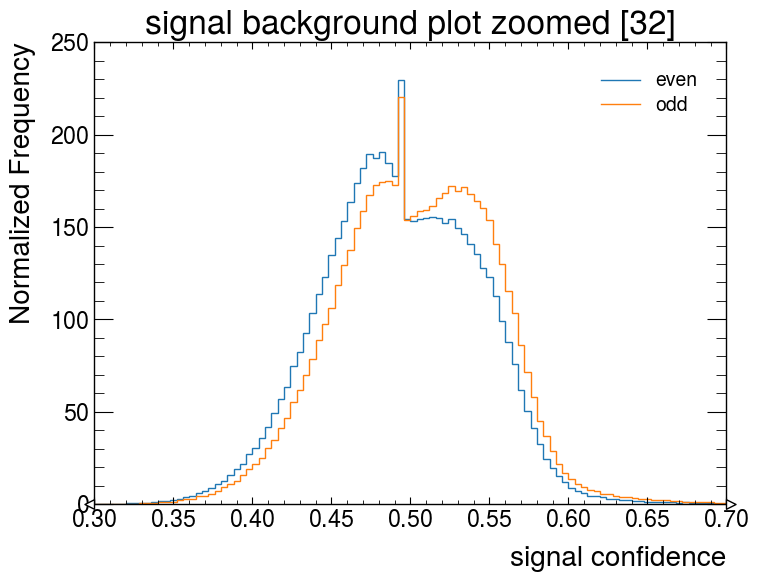

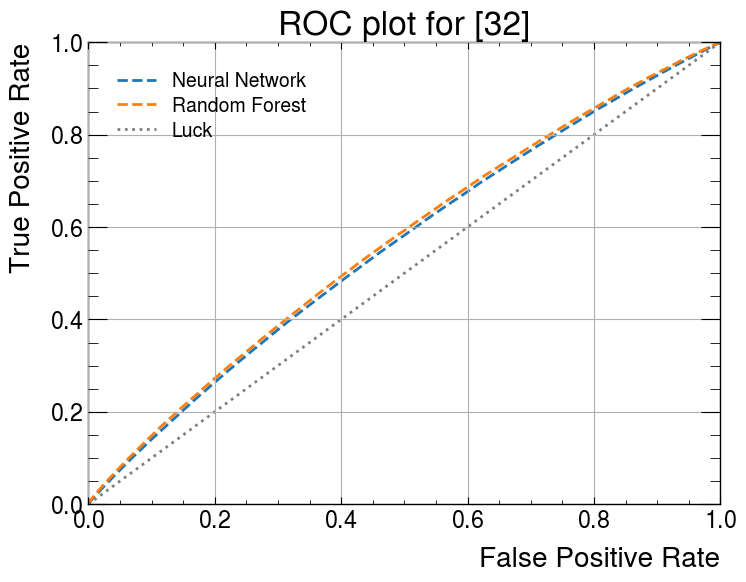

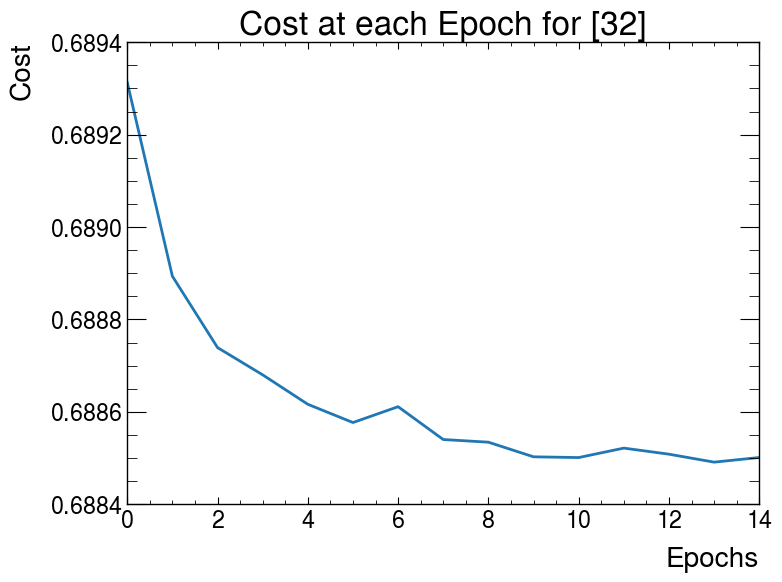

Epoch: 0, Train Loss: 0.689218
time for epoch: 36.68 s
Validation Loss: 0.697162, Validation Accuracy: 0.480000
Epoch: 1, Train Loss: 0.688799
time for epoch: 36.56 s
Validation Loss: 0.692816, Validation Accuracy: 0.470000
Epoch: 2, Train Loss: 0.688703
time for epoch: 35.96 s
Validation Loss: 0.696432, Validation Accuracy: 0.480000
Epoch: 3, Train Loss: 0.688643
time for epoch: 36.57 s
Validation Loss: 0.697249, Validation Accuracy: 0.480000
Epoch: 4, Train Loss: 0.688576
time for epoch: 41.32 s
Validation Loss: 0.691256, Validation Accuracy: 0.520000
Epoch: 5, Train Loss: 0.688537
time for epoch: 39.23 s
Validation Loss: 0.695549, Validation Accuracy: 0.450000
Epoch: 6, Train Loss: 0.688596
time for epoch: 38.99 s
Validation Loss: 0.691211, Validation Accuracy: 0.490000
Epoch: 7, Train Loss: 0.688534
time for epoch: 41.49 s
Validation Loss: 0.695571, Validation Accuracy: 0.470000
Epoch: 8, Train Loss: 0.688524
time for epoch: 39.13 s
Validation Loss: 0.692573, Validation Accuracy: 0

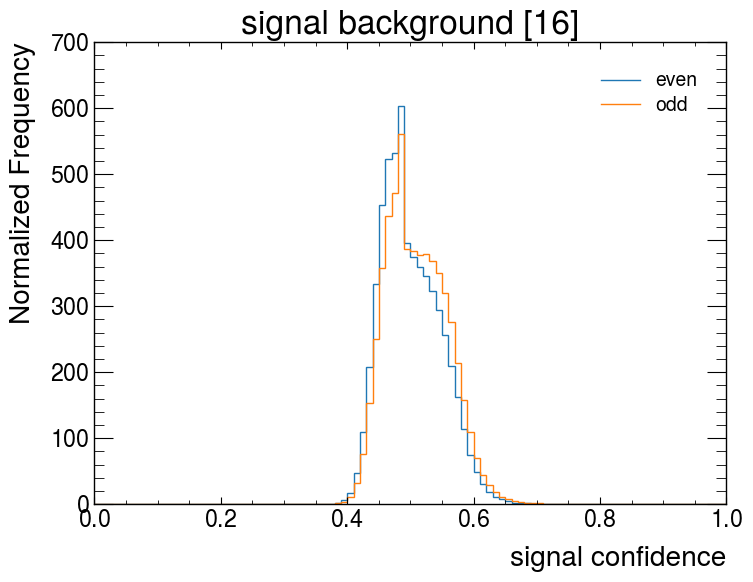

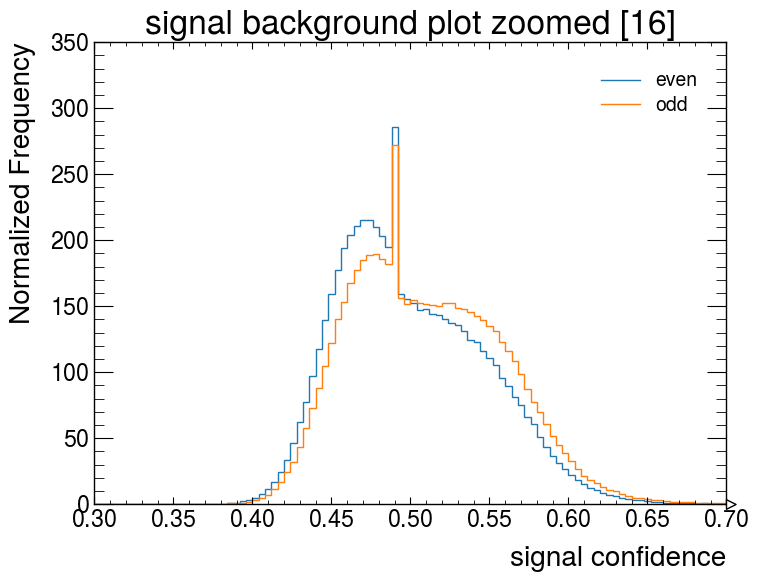

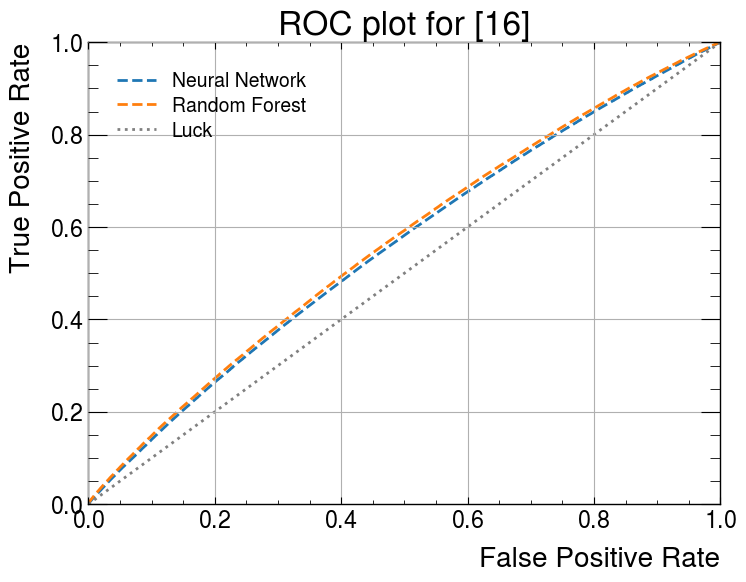

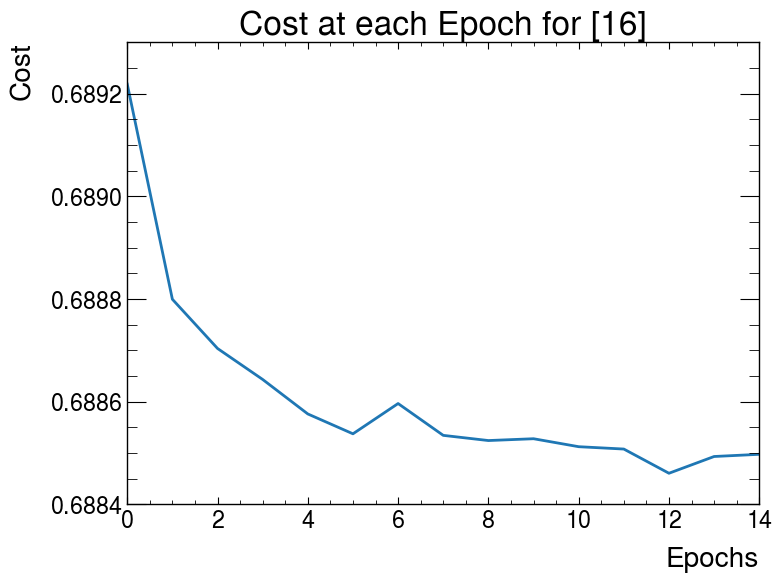

Epoch: 0, Train Loss: 0.689255
time for epoch: 39.82 s
Validation Loss: 0.687977, Validation Accuracy: 0.550000
Epoch: 1, Train Loss: 0.688715
time for epoch: 43.77 s
Validation Loss: 0.695992, Validation Accuracy: 0.510000
Epoch: 2, Train Loss: 0.688642
time for epoch: 39.11 s
Validation Loss: 0.696788, Validation Accuracy: 0.520000
Epoch: 3, Train Loss: 0.688611
time for epoch: 36.57 s
Validation Loss: 0.699908, Validation Accuracy: 0.460000
Epoch: 4, Train Loss: 0.688558
time for epoch: 36.86 s
Validation Loss: 0.693771, Validation Accuracy: 0.530000
Epoch: 5, Train Loss: 0.688554
time for epoch: 36.05 s
Validation Loss: 0.692938, Validation Accuracy: 0.510000
Epoch: 6, Train Loss: 0.688532
time for epoch: 36.49 s
Validation Loss: 0.688923, Validation Accuracy: 0.550000
Epoch: 7, Train Loss: 0.688541
time for epoch: 36.39 s
Validation Loss: 0.702223, Validation Accuracy: 0.430000
Epoch: 8, Train Loss: 0.688538
time for epoch: 39.47 s
Validation Loss: 0.697769, Validation Accuracy: 0

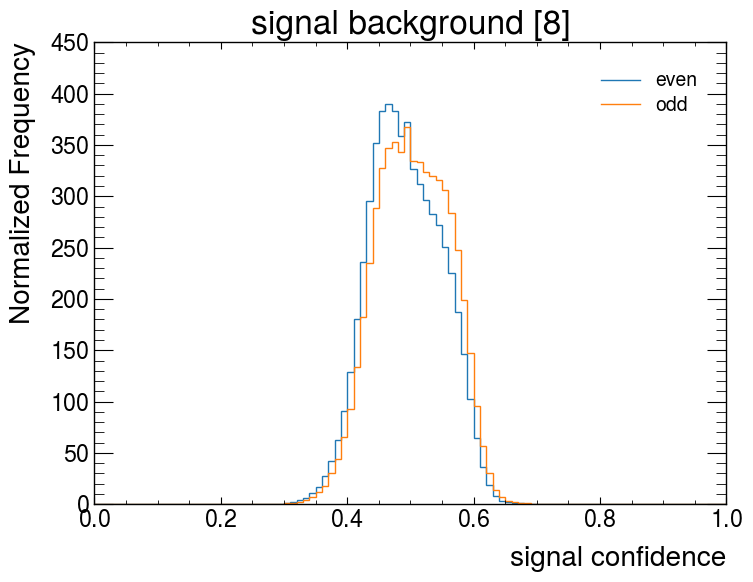

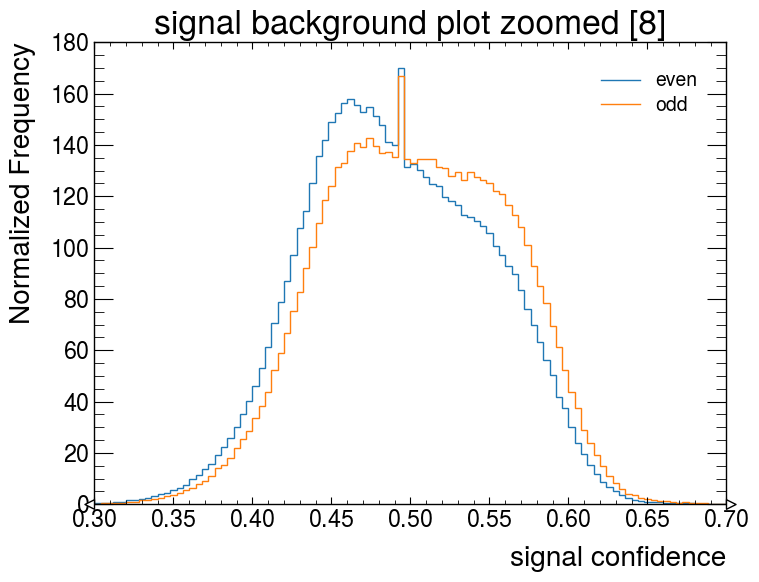

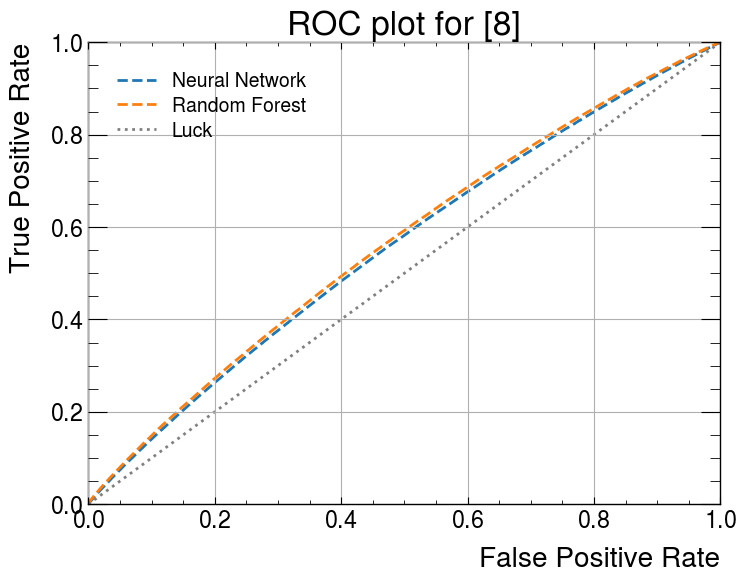

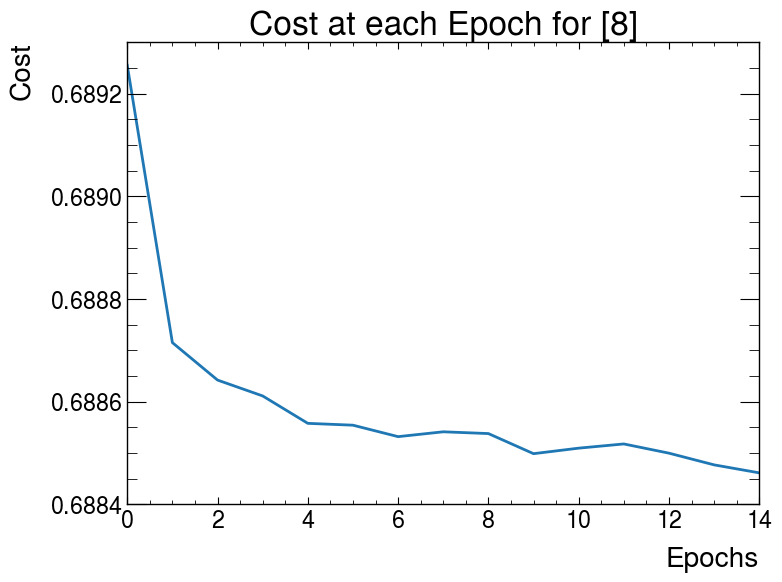

Epoch: 0, Train Loss: 0.689857
time for epoch: 50.08 s
Validation Loss: 0.701945, Validation Accuracy: 0.530000
Epoch: 1, Train Loss: 0.689173
time for epoch: 51.86 s
Validation Loss: 0.692105, Validation Accuracy: 0.500000
Epoch: 2, Train Loss: 0.688999
time for epoch: 57.39 s
Validation Loss: 0.692843, Validation Accuracy: 0.520000
Epoch: 3, Train Loss: 0.688822
time for epoch: 55.06 s
Validation Loss: 0.691741, Validation Accuracy: 0.530000
Epoch: 4, Train Loss: 0.688776
time for epoch: 56.43 s
Validation Loss: 0.684836, Validation Accuracy: 0.500000
Epoch: 5, Train Loss: 0.688694
time for epoch: 59.81 s
Validation Loss: 0.692923, Validation Accuracy: 0.520000
Epoch: 6, Train Loss: 0.688652
time for epoch: 58.16 s
Validation Loss: 0.701145, Validation Accuracy: 0.430000
Epoch: 7, Train Loss: 0.688595
time for epoch: 60.16 s
Validation Loss: 0.686275, Validation Accuracy: 0.550000
Epoch: 8, Train Loss: 0.688550
time for epoch: 62.63 s
Validation Loss: 0.693762, Validation Accuracy: 0

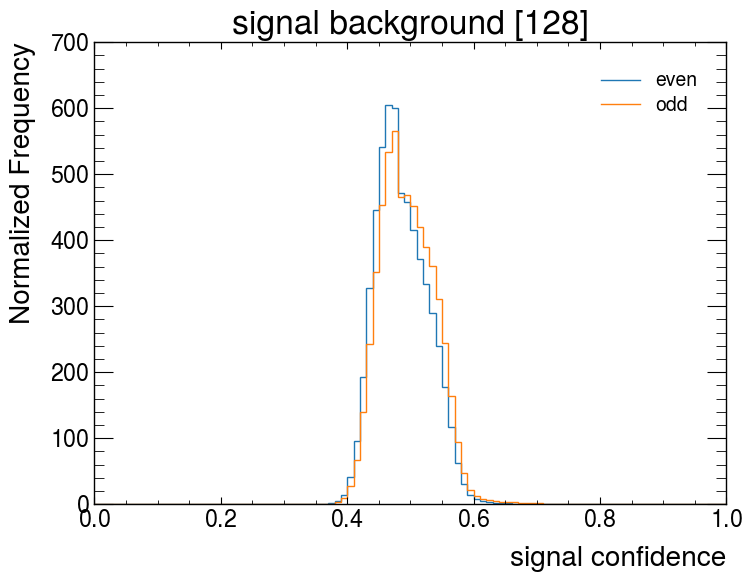

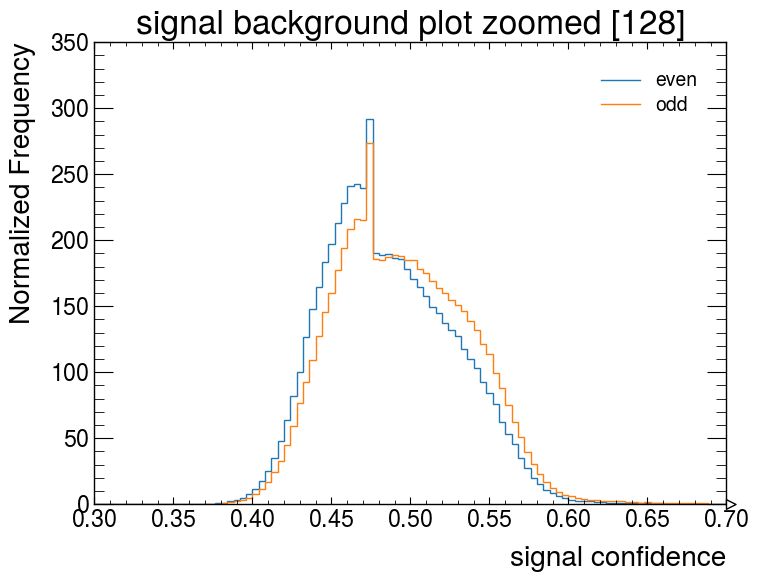

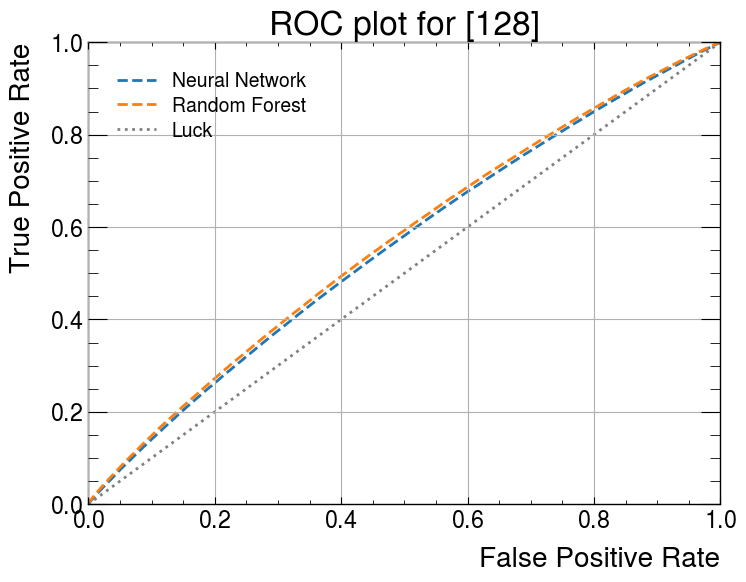

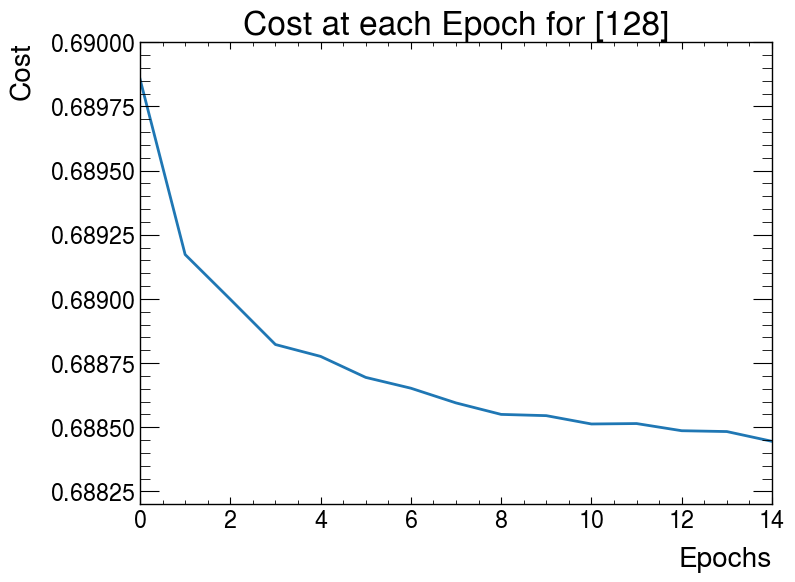

Epoch: 0, Train Loss: 0.689014
time for epoch: 50.79 s
Validation Loss: 0.695205, Validation Accuracy: 0.480000
Epoch: 1, Train Loss: 0.688571
time for epoch: 53.34 s
Validation Loss: 0.689288, Validation Accuracy: 0.560000
Epoch: 2, Train Loss: 0.688514
time for epoch: 54.57 s
Validation Loss: 0.693360, Validation Accuracy: 0.480000
Epoch: 3, Train Loss: 0.688421
time for epoch: 54.35 s
Validation Loss: 0.685993, Validation Accuracy: 0.540000
Epoch: 4, Train Loss: 0.688349
time for epoch: 52.07 s
Validation Loss: 0.688518, Validation Accuracy: 0.520000
Epoch: 5, Train Loss: 0.688260
time for epoch: 50.99 s
Validation Loss: 0.688846, Validation Accuracy: 0.550000
Epoch: 6, Train Loss: 0.688233
time for epoch: 51.34 s
Validation Loss: 0.695669, Validation Accuracy: 0.500000
Epoch: 7, Train Loss: 0.688202
time for epoch: 51.11 s
Validation Loss: 0.693160, Validation Accuracy: 0.520000
Epoch: 8, Train Loss: 0.688195
time for epoch: 50.98 s
Validation Loss: 0.690834, Validation Accuracy: 0

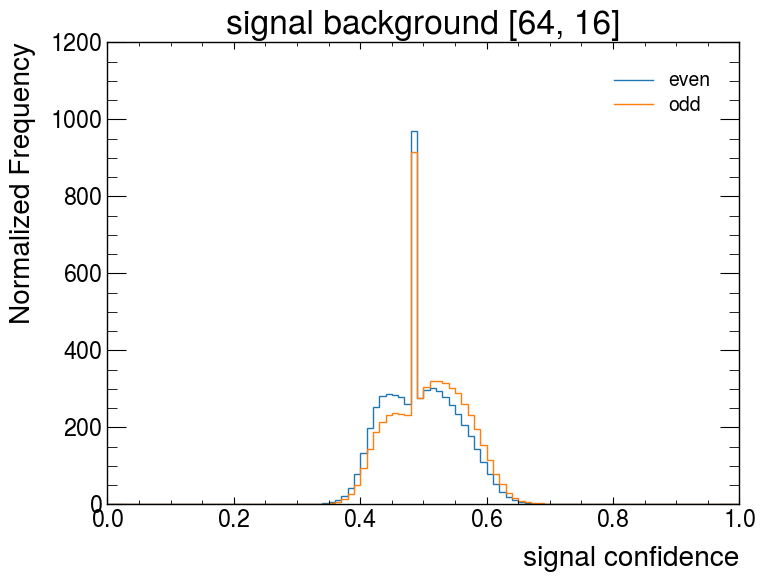

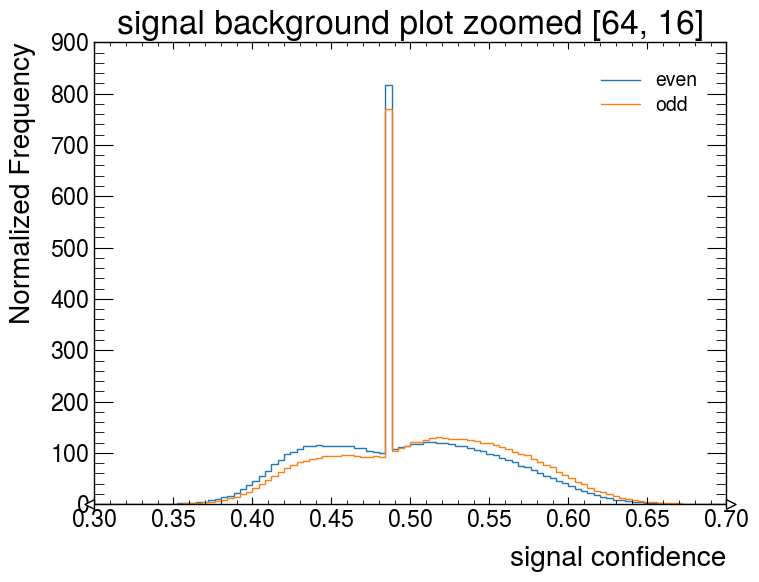

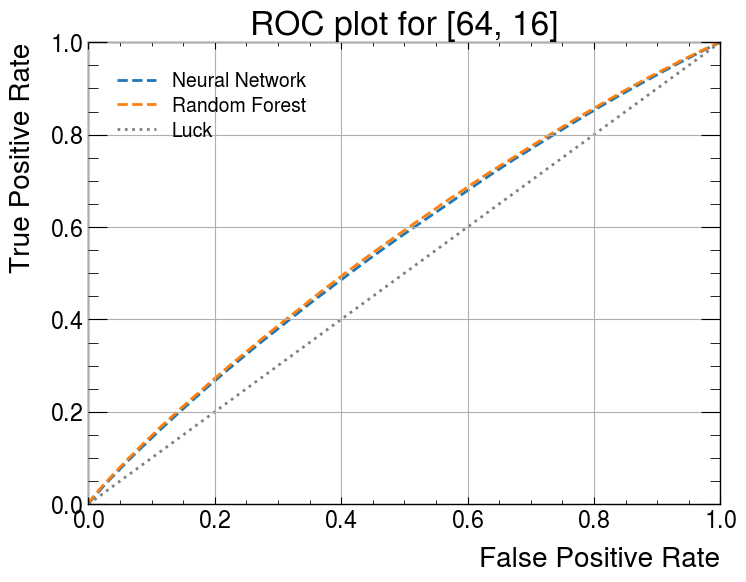

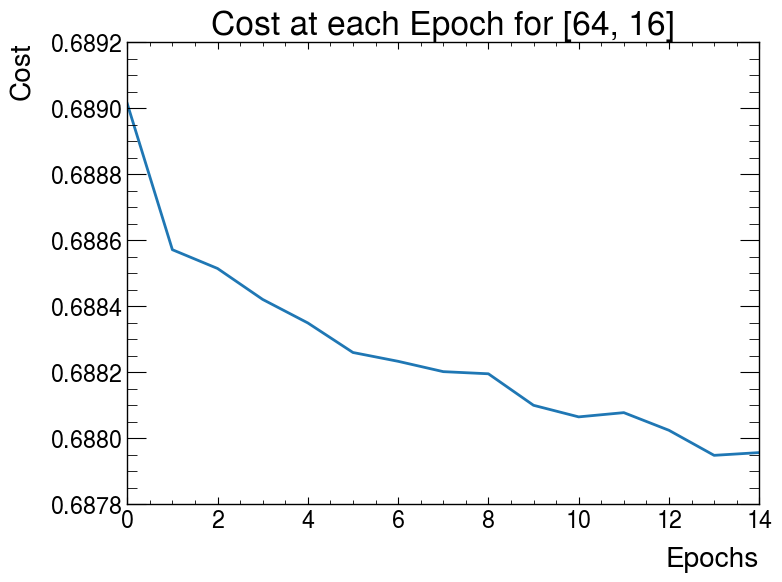

In [168]:
models = do_it_all(dimes, 'Adam')

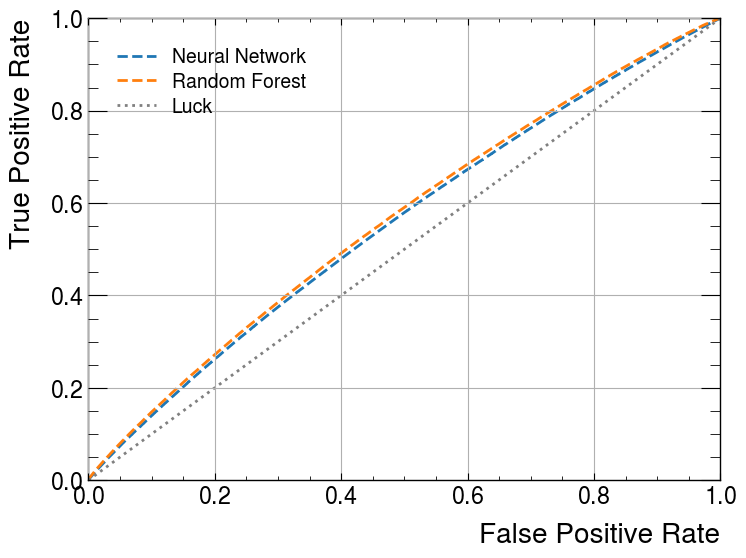

In [85]:
X_tensor = torch.as_tensor(X_scaled, dtype=torch.float)  
X_var = torch.autograd.Variable(X_tensor)


decisions_nn = (NN_clf(X_var)[1][:, 1].cpu().detach().numpy())  # get the decisions of the neural network
fpr_nn, tpr_nn, thresholds_nn = sklearn.metrics.roc_curve(y, decisions_nn)  # get FPRs, TPRs and thresholds for neural network

decisions_rf = RF_clf.predict_proba(X_scaled)[:, 1]  # get the decisions of the random forest  # get the decisions of the neural network
fpr_rf, tpr_rf, thresholds_rf = sklearn.metrics.roc_curve(y, decisions_rf)  # get FPRs, TPRs and thresholds for neural network

plt.plot(fpr_nn, tpr_nn, linestyle="dashed", label="Neural Network")  # plot neural network ROC
plt.plot(fpr_rf, tpr_rf, linestyle="dashed", label="Random Forest")
plt.plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")  # plot diagonal line to indicate luck
plt.xlabel("False Positive Rate")  # x-axis label
plt.ylabel("True Positive Rate")  # y-axis label
plt.ylim(0,1)
plt.grid()  # add a grid to the plot
plt.legend()  # add a legend
plt.show()


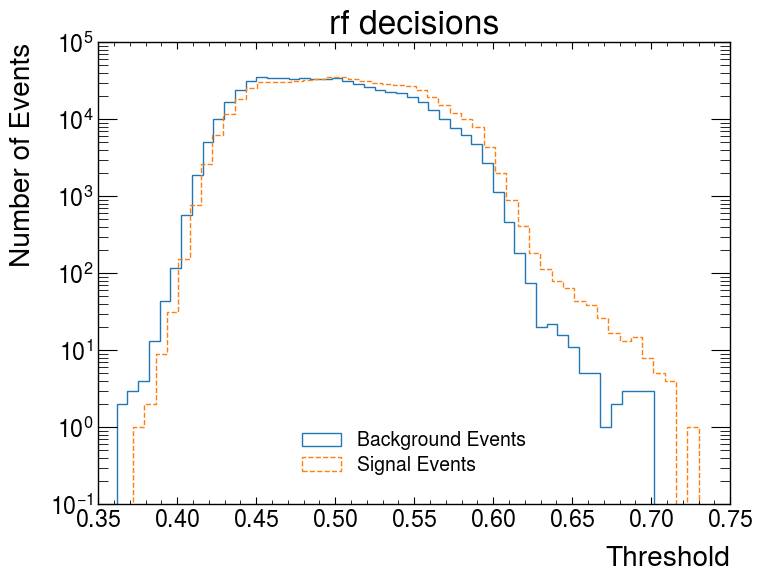

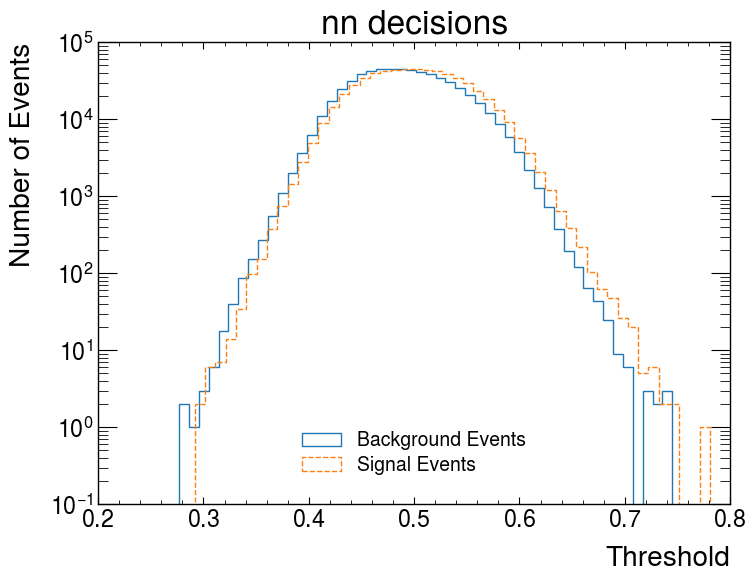

In [91]:
plt.hist(decisions_rf[y == 0], histtype="step", bins=50, label="Background Events")  # plot background
plt.hist(decisions_rf[y == 1],histtype="step",bins=50,linestyle="dashed",label="Signal Events",)  # plot signal
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("Number of Events")  # y-axis label
plt.semilogy()  # make the y-axis semi-log
plt.legend()  # draw the legend
plt.title('rf decisions')
plt.show()

plt.hist(decisions_nn[y == 0], histtype="step", bins=50, label="Background Events")  # plot background
plt.hist(decisions_nn[y == 1],histtype="step",bins=50,linestyle="dashed",label="Signal Events",)  # plot signal
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("Number of Events")  # y-axis label
plt.semilogy()  # make the y-axis semi-log
plt.legend()  # draw the legend
plt.title('nn decisions')
plt.show()

In [92]:
def AMS(tpr, fpr, b_reg):
    part1 = 1 + tpr/(fpr+b_reg)
    part2 = (tpr+fpr+b_reg)*np.log(part1)-tpr
    return np.sqrt(2*part2)

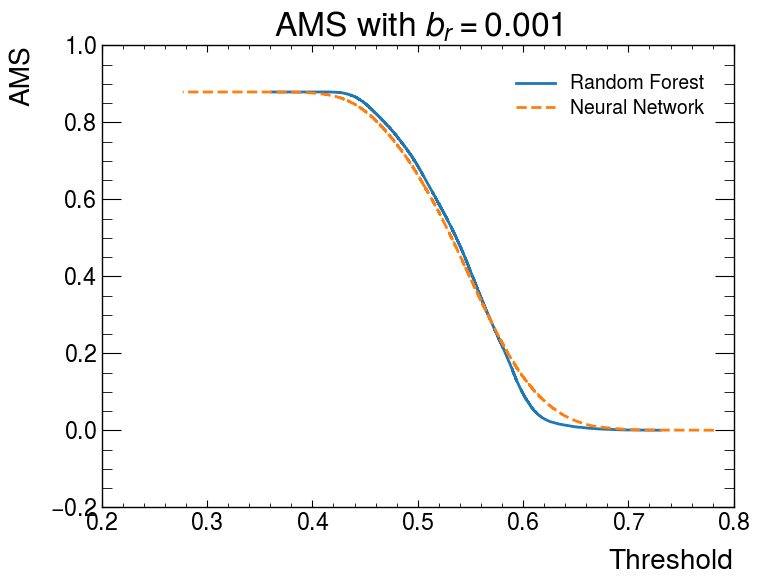

In [93]:
ams_rf = AMS(tpr_rf, fpr_rf, 0.001)
ams_nn = AMS(tpr_nn, fpr_nn, 0.001)

plt.plot(thresholds_rf, ams_rf, label="Random Forest")  # plot random forest AMS
plt.plot(thresholds_nn, ams_nn, linestyle="dashed", label="Neural Network")  # plot neural network AMS
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("AMS")  # y-axis label
plt.title("AMS with $b_r=0.001$")  # add plot title
plt.legend()  # add legend